# Karchow RL with PPO

Credits to Grant Cheng (GitHub: CatFish47).

Install anything necessary for stable baselines and open ai gym.

In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install stable-baselines3[extra]
!pip install gym --upgrade
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Using cached gym-0.21.0-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.23.1
    Uninstalling gym-0.23.1:
      Successfully uninstalled gym-0.23.1
  Using cached gym-0.23.1-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 1.5.0 requires gym==0.21, but you have gym 0.23.1 which is incompatible.


Mount notebook to Google drive, where the checkpoint data for the is stored.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary components for the model and environment. Create the environment.

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import imageio
import os
import numpy as np

# Parallel environments
env = make_vec_env("CarRacing-v1", n_envs=4)

# model = PPO("CnnPolicy", env, learning_rate=0.0003, n_steps=1024, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, seed=8, verbose=1)
# model = PPO.load("/content/drive/MyDrive/PPO/ppo_racing2", env=env)
# model.learn(total_timesteps=62_500)

Save the model to drive after finishing training.

In [ ]:
# model.save("/content/drive/MyDrive/PPO/ppo_racing3")

Load a model that's been stored in drive.

In [ ]:
model = PPO.load("/content/drive/MyDrive/PPO/ppo_racing1", env=env)

Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


Create a validation stage.

In [ ]:
def average_rewards(r):
  return np.sum(r)/len(r)

In [ ]:
#Validation
from tqdm import tqdm
obs = env.reset()
frames = []
avg_reward = 0
for i in tqdm(range(1000)):
  action, _states = model.predict(obs.copy(), deterministic=True)
  obs, reward, done, info = env.step(action)
  avg_reward += average_rewards(reward)
  frames.append(env.render("rgb_array"))
  if done.all():
    obs = env.reset()
    break

env.close()

path = os.path.join(f"eval.mp4")
frames = np.array(frames)

Track generation: 957..1209 -> 252-tiles track
Track generation: 1127..1413 -> 286-tiles track
Track generation: 1191..1493 -> 302-tiles track
Track generation: 993..1253 -> 260-tiles track


100%|█████████▉| 999/1000 [03:52<00:00,  4.40it/s]

Track generation: 1196..1499 -> 303-tiles track
Track generation: 1364..1709 -> 345-tiles track
Track generation: 1180..1479 -> 299-tiles track
Track generation: 988..1242 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1121..1414 -> 293-tiles track
Track generation: 1034..1297 -> 263-tiles track


100%|█████████▉| 999/1000 [03:52<00:00,  4.29it/s]

Track generation: 1120..1404 -> 284-tiles track
Track generation: 1147..1438 -> 291-tiles track
Track generation: 1145..1440 -> 295-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1187..1488 -> 301-tiles track


Save the video.

In [ ]:
# imageio.mimsave(path, frames, fps=60)

Create a rewards graph using the average reward during the validation stage.

In [ ]:
avg_reward

869.8522652685642

In [ ]:
#average cumulative rewards over 5 different periods
# None: 31.030509762465954
# 62500: 327.19548013806343
# 125000: 869.8522652685642
# 187500: 591.970870397985
# 250000: 963.6337747052312

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

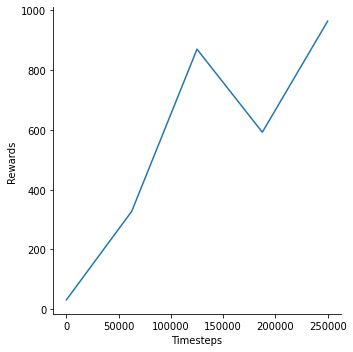

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

rewards_data = [31.030509762465954, 327.19548013806343, 869.8522652685642, 591.970870397985, 963.6337747052312]
data = pd.DataFrame(data={"Timesteps": [0, 62_500, 125_000, 187_500, 250_000], "Rewards": rewards_data})
sns.relplot(data=data, x="Timesteps", y="Rewards", kind="line")
plt.savefig('rewards_graph.png')